## Facial Key Point Detection

This is using the Kaggle Dataset, wherein the training data has labels for 15 different coordinates (x,y) on an individual's face, making it 30 labels in total.  This is so because, these are the key points that help identify an individual's face.

The goal of this exercise is to build a Deep Neural Network using Keras and make predictions on the validation / test datasets.  Validation dataset is part (20%) of the original training dataset that was identified as good ones with all labels.  Test dataset is the original test set from Kaggle website and does not have labels for us to validate.  However, we can predict on the test set and plot the predictions on the images to visually validate our model's performance.

We will use Keras library for this exercise and try tuning several hyper-parameters to identify what gets best results.  Hyper-parameters tuned includes optimizers, filters, kernel size, number of convolutional layers etc.  Further enhancements can be done by applying blurring, contrast enhancements etc. using image processing techniques.

In [1]:
import cv2
#from utils import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras import optimizers
from keras import backend as K

C:\Users\sudha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import pandas as pd
from sklearn.model_selection import train_test_split

### Load Dataset

The following function loads the dataset and does clean-up to exclude ones with missing labels.  The training data and labels are then returned to the calling function.


In [5]:
def load(test=False):
    """ Function to load the dataset into np arrays
    
        Argument: 
        test - boolean value to indicate 'test' if True and 'training' if False 

        Returns: 
        X: np array holding training / test data
        y: np array holding labels
        cols: column names (30 data points that are labels)
    """
    
    # files for training and test datasets
    FTRAIN = 'training/training.csv'
    FTEST = 'test/test.csv'
    
    filename = FTEST if test else FTRAIN

    df = read_csv(os.path.expanduser(filename))
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    cols = df.columns
    
    # normalize values
    X = np.vstack(df['Image'].values)/255.

    # labels missing in training should be removed from training
    if (test==False):
        y = df[df.columns[0:30]].values
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        X, y = shuffle(X, y, random_state=42)
    else:
        y = None
        cols = None

    X = X.astype(np.float32)
    
    # return X (data), y (labels) and cols (column names)
    return X, y, cols

def load_2D(test=False):
    """ Load into 2D by reshaping
    
        Argument: 
        test - boolean value to indicate 'test' if True and 'training' if False 

        Returns: 
        X: np array holding training / test data
        y: np array holding labels
        cols: column names (30 data points that are labels)
    """
    X, y, cols = load(test)
    X = X.reshape(-1, 96, 96, 1)
    
    return X, y, cols

In [6]:
# Load training data
X_train, y_train, label_cols = load_2D(test=False)


In [7]:
# implicitly split the training dataset into 'train' and 'validation' datasets (test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
print("Train data shape: ", X_train.shape, " and Train label shape: ", y_train.shape)
print("Labels: ", label_cols[:-1])

Train data shape:  (1712, 96, 96, 1)  and Train label shape:  (1712, 30)
Labels:  Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')


In [9]:
print("Validation dataset shape: ", X_valid.shape, " and Validation label shape: ", y_valid.shape)

Validation dataset shape:  (428, 96, 96, 1)  and Validation label shape:  (428, 30)


In [10]:
# Load training data
X_test, y_test, label_cols = load_2D(test=True)


In [11]:
print("Test data shape: ", X_test.shape, " and Test label shape: ", y_test)
print("Labels: ", label_cols)

Test data shape:  (1783, 96, 96, 1)  and Test label shape:  None
Labels:  None


### Plot a few sample images

Let's try to plot a few sample images from the training / validation datasets, also plotting the facial keypoints using the label values.


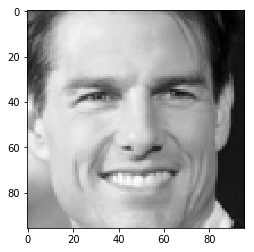

In [12]:
# plot a sample image in gray scale from training dataset
plt.imshow(X_train[1].reshape(96,96), cmap='gray')

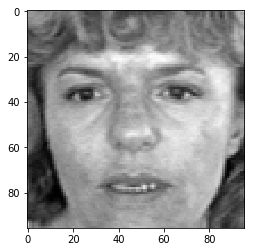

In [13]:
# plot a sample image in gray scale from validation dataset
plt.imshow(X_valid[1].reshape(96,96), cmap='gray')

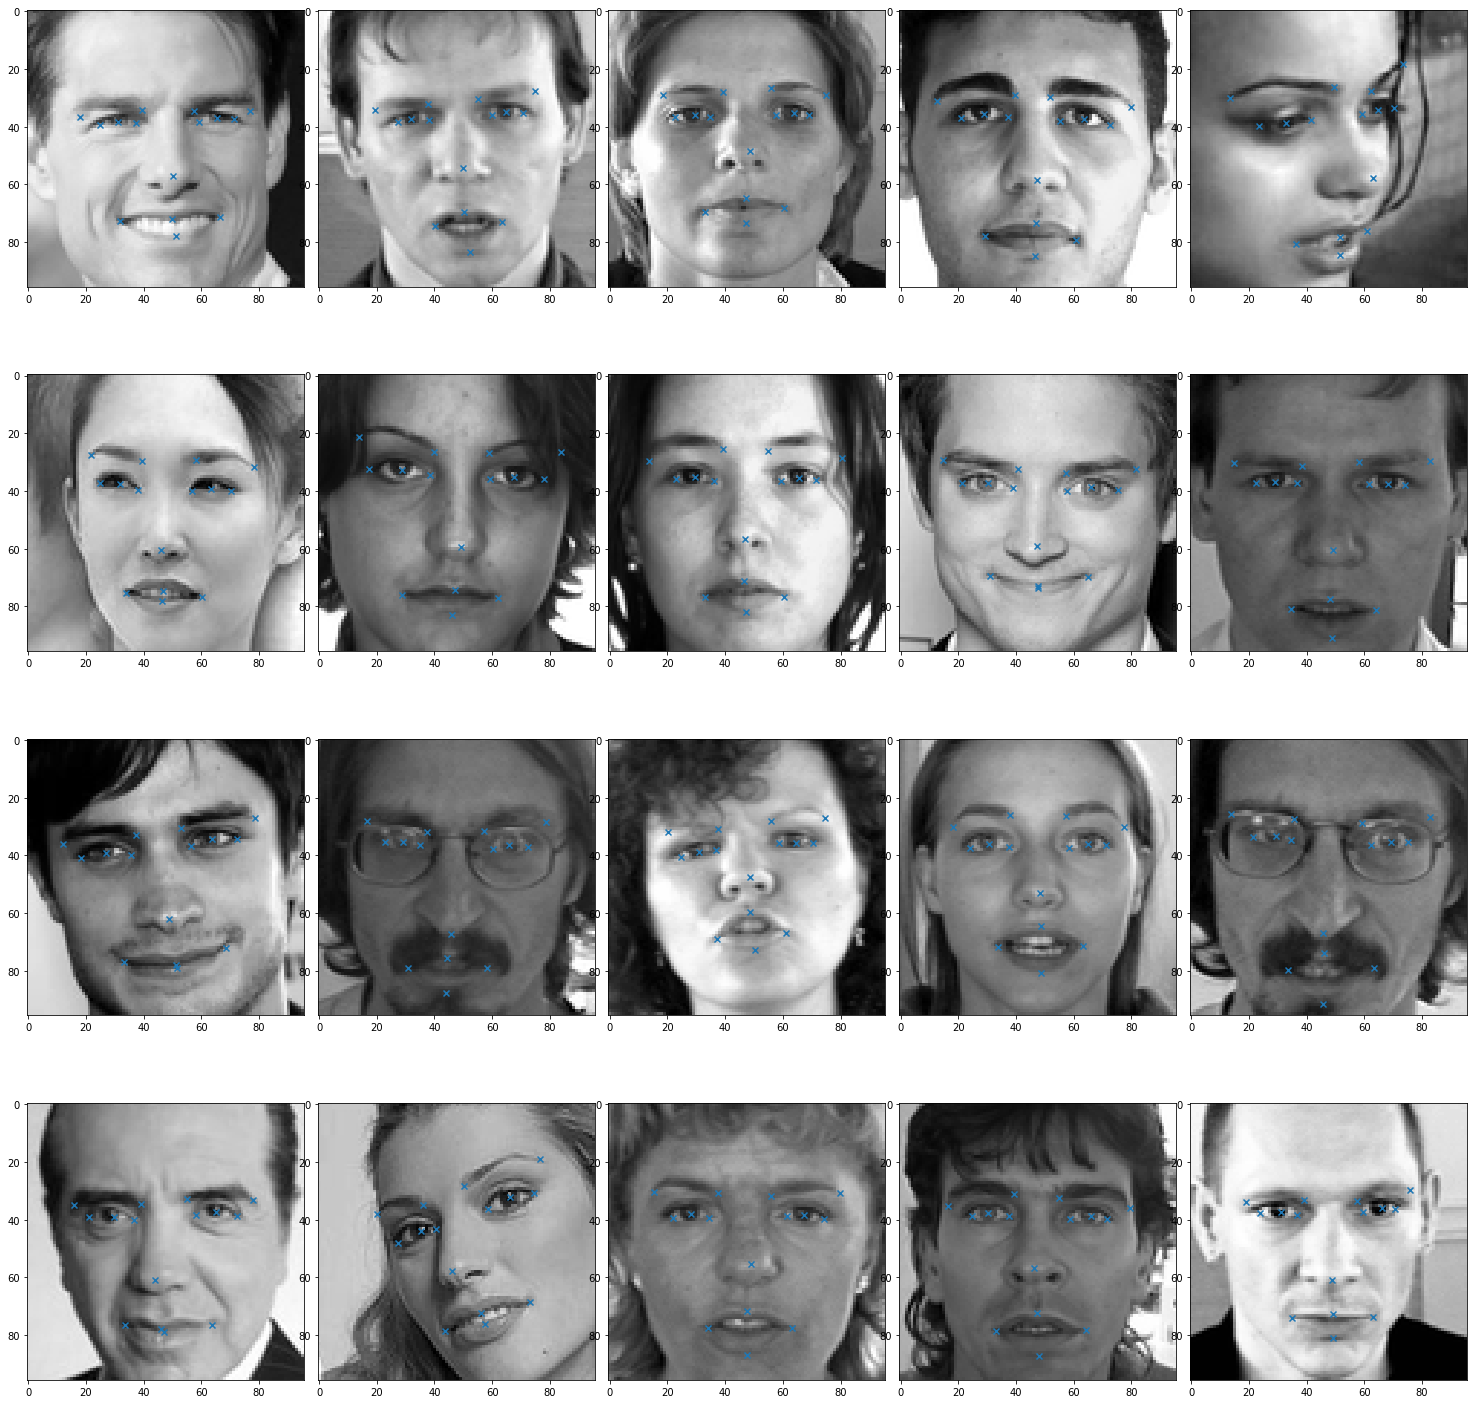

In [15]:
# plot a few sample images in gray scale from training dataset with labels
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i, :, :, 0].reshape(96,96), cmap='gray')
    plt.scatter(y_train[i, range(0,30,2)], y_train[i, range(1,30,2)], marker='x')
    
plt.show()

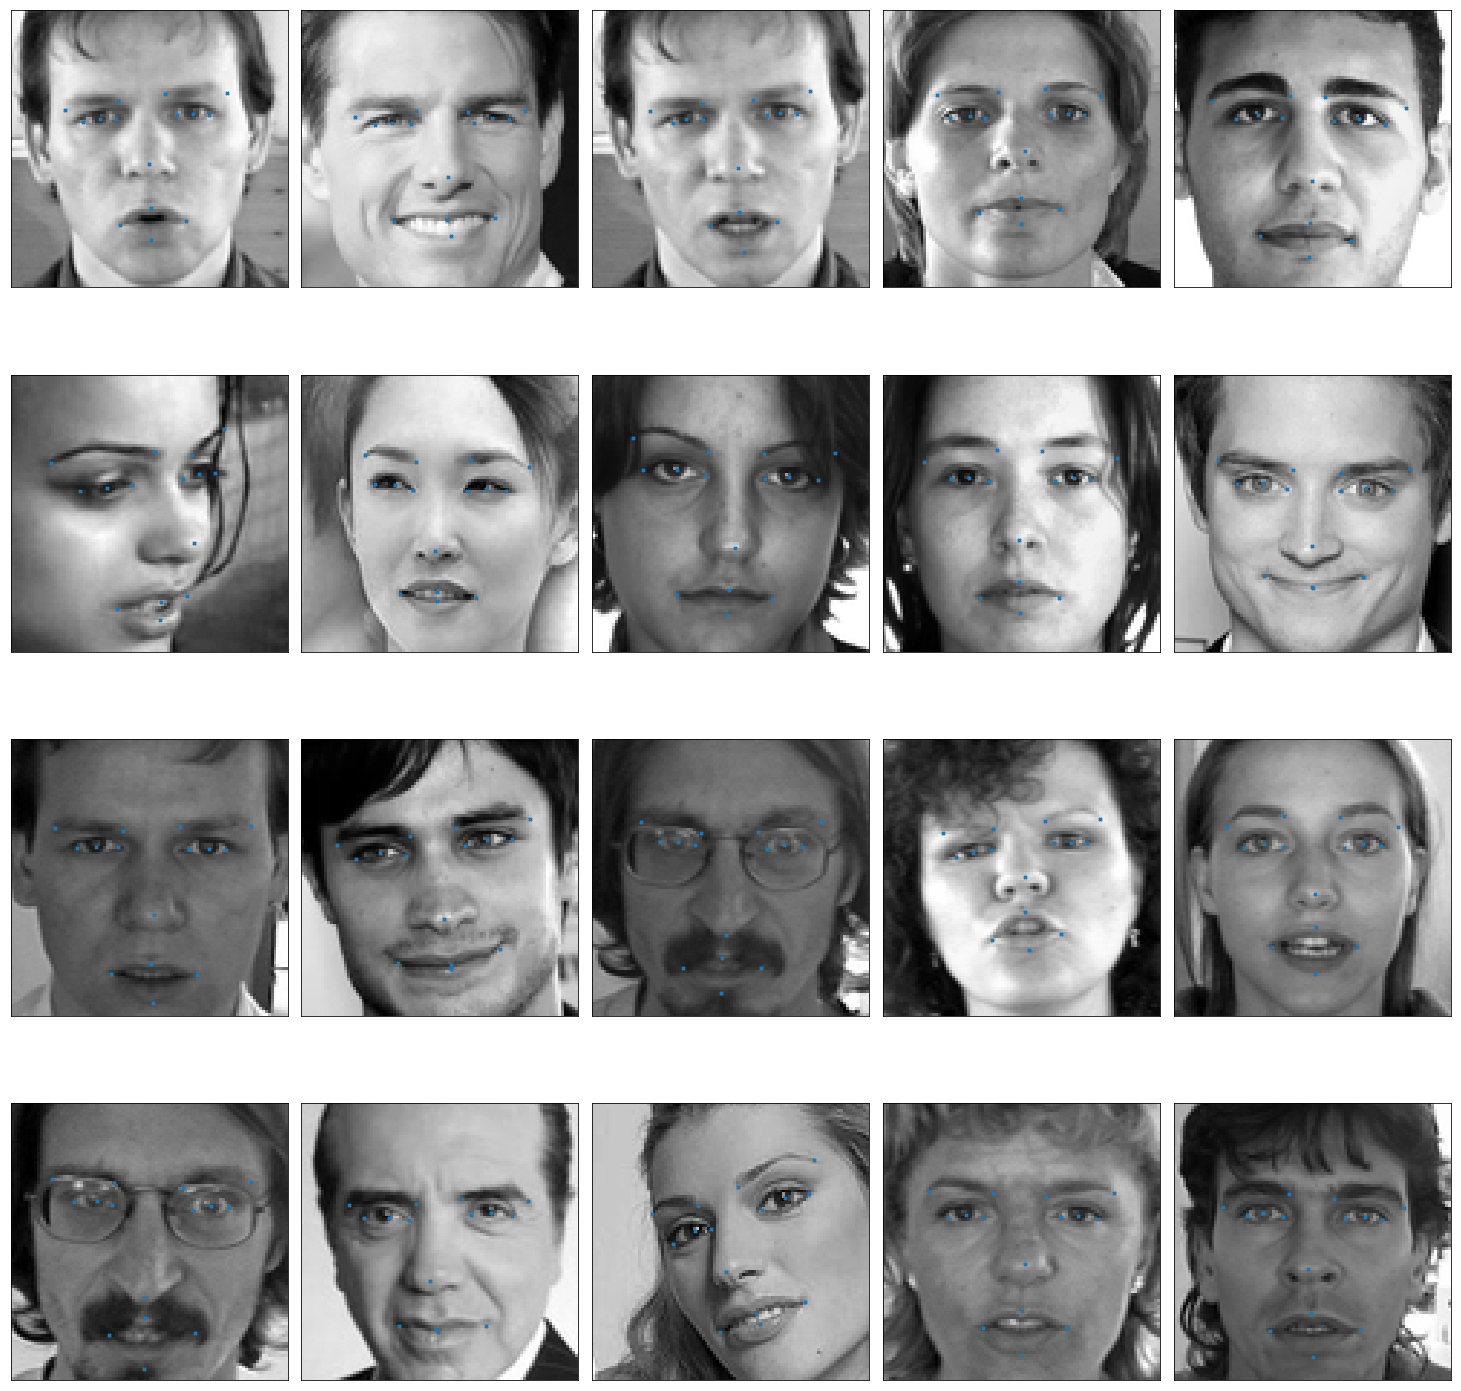

In [17]:
# plot a few sample images in gray scale from training dataset with labels
def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_train[i], y_train[i], ax)
    
plt.show()

## Set Parameters

Set parameters to iterate and build models for so that it can be displayed on TensorBoard.

In [18]:
import time
from keras import backend as K
from keras.callbacks import TensorBoard
from os import makedirs
from os.path import exists, join

#### Define Metrics

Here, we are dealing with a regression problem, as we are trying to predict coordinate values for facial keypoints.  A good measure to understand how the model performs is the RMSE (Root Mean Squared Error).  We define a function to calculate both rmse and r_square to include in our call to the model.  

Also, we define a folder to capture log of the various runs to display as a TensorBoard.  The directory is created, if it doesn't already exist.


In [20]:
log_dir = './logs'
if not exists(log_dir):
    makedirs(log_dir)
    
    
# define custom metric rmse as this is a regression problem
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# define r_square as custom metric
# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )



## Define Multiple Models (with Dropout)

Here, we are trying to loop through various combinations of the following parameters:

* Number of dense layers (1 or 2)
* Layer sizes for the convolution layer (48 or 64)
* Number of convolution layer (1, 2 or 3)

By building the models to the above combinations, we get to compare among 12 (2 x 2 x 3) different models run for same batch size and 20 epochs.  This is to identify the top 2 best models and run them for 50 epochs to see if we are able to reduce the 'rmse' value further.


## Iterative Model Runs with Tensorboard

The details of each run is logged into a folder so that we can view the same in a TensorBoard.  Each model run is given a unique name based on the parameters that differentiate it, tagged with the time of the run.


In [21]:
# Repeat the above exercise by adding a Dropout Layer
dense_layers=[1,2]
layer_sizes=[48,64]
conv_layers=[1,2,3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME="{}-conv-{}-layer-{}-dense-DO-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            
            model = Sequential()
            model.add(BatchNormalization(input_shape=(96,96,1)))

            # Add convolutional layer with kernel size as 3, 'relu' activation and 'MaxPooling' 
            model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            for cl in range(conv_layer - 1):
                model.add(Conv2D(filters=layer_size, kernel_size=(3,3)) )
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            # Add a layer to flatten before feeding into dense layers
            model.add(Flatten())

            # Add dropout layer to address overfitting issues
            model.add(Dropout(0.3))

            for dl in range(dense_layer):
                # Add dense layer with 100 neurons + 'relu' activation
                model.add(Dense(200))
                model.add(Activation("relu"))

            # Output layer for the 30 labels to be predicted
            model.add(Dense(30))

            # choose 'adam' optimizer and 'mean_squared_error' as loss function; custom metrics for evaluation
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
            
            model.fit(X_train, y_train, 
                      epochs=20, batch_size=100, 
                      validation_split=0, validation_data=(X_valid, y_valid), 
                      verbose=2, 
                      callbacks=[tensorboard])

1-conv-48-layer-1-dense-DO-1543885805
Train on 1712 samples, validate on 428 samples
Epoch 1/20
 - 18s - loss: 590.9478 - rmse: 22.1622 - acc: 0.2500 - mean_absolute_error: 17.9640 - r_square: -6.7118e-01 - val_loss: 179.6623 - val_rmse: 13.4008 - val_acc: 0.0327 - val_mean_absolute_error: 10.6495 - val_r_square: 0.4929
Epoch 2/20
 - 18s - loss: 126.5718 - rmse: 11.1980 - acc: 0.5012 - mean_absolute_error: 8.5616 - r_square: 0.6431 - val_loss: 93.4578 - val_rmse: 9.6650 - val_acc: 0.2593 - val_mean_absolute_error: 7.1576 - val_r_square: 0.7361
Epoch 3/20
 - 18s - loss: 78.3984 - rmse: 8.8298 - acc: 0.5882 - mean_absolute_error: 6.6441 - r_square: 0.7788 - val_loss: 65.1810 - val_rmse: 8.0702 - val_acc: 0.6846 - val_mean_absolute_error: 5.9856 - val_r_square: 0.8160
Epoch 4/20
 - 18s - loss: 56.7663 - rmse: 7.4963 - acc: 0.6548 - mean_absolute_error: 5.5538 - r_square: 0.8398 - val_loss: 48.0767 - val_rmse: 6.9265 - val_acc: 0.6729 - val_mean_absolute_error: 5.0727 - val_r_square: 0.864

Epoch 17/20
 - 20s - loss: 8.1184 - rmse: 2.8449 - acc: 0.7325 - mean_absolute_error: 2.0750 - r_square: 0.9771 - val_loss: 8.1825 - val_rmse: 2.8574 - val_acc: 0.7079 - val_mean_absolute_error: 2.0608 - val_r_square: 0.9769
Epoch 18/20
 - 21s - loss: 7.6155 - rmse: 2.7540 - acc: 0.7278 - mean_absolute_error: 1.9949 - r_square: 0.9785 - val_loss: 7.2387 - val_rmse: 2.6863 - val_acc: 0.7056 - val_mean_absolute_error: 1.9047 - val_r_square: 0.9796
Epoch 19/20
 - 21s - loss: 7.1424 - rmse: 2.6659 - acc: 0.7284 - mean_absolute_error: 1.9291 - r_square: 0.9799 - val_loss: 7.2238 - val_rmse: 2.6847 - val_acc: 0.7033 - val_mean_absolute_error: 1.9293 - val_r_square: 0.9796
Epoch 20/20
 - 20s - loss: 6.8294 - rmse: 2.6080 - acc: 0.7442 - mean_absolute_error: 1.8870 - r_square: 0.9807 - val_loss: 8.1404 - val_rmse: 2.8510 - val_acc: 0.6986 - val_mean_absolute_error: 2.0957 - val_r_square: 0.9770
3-conv-48-layer-1-dense-DO-1543886617
Train on 1712 samples, validate on 428 samples
Epoch 1/20
 - 2

Epoch 13/20
 - 19s - loss: 11.2758 - rmse: 3.3430 - acc: 0.7558 - mean_absolute_error: 2.3790 - r_square: 0.9682 - val_loss: 14.5385 - val_rmse: 3.7997 - val_acc: 0.7173 - val_mean_absolute_error: 2.6589 - val_r_square: 0.9590
Epoch 14/20
 - 18s - loss: 10.3399 - rmse: 3.2073 - acc: 0.7500 - mean_absolute_error: 2.2642 - r_square: 0.9708 - val_loss: 13.8237 - val_rmse: 3.6974 - val_acc: 0.7196 - val_mean_absolute_error: 2.4835 - val_r_square: 0.9610
Epoch 15/20
 - 18s - loss: 9.5452 - rmse: 3.0782 - acc: 0.7535 - mean_absolute_error: 2.1922 - r_square: 0.9731 - val_loss: 12.9184 - val_rmse: 3.5697 - val_acc: 0.7079 - val_mean_absolute_error: 2.4356 - val_r_square: 0.9636
Epoch 16/20
 - 18s - loss: 8.9429 - rmse: 2.9760 - acc: 0.7576 - mean_absolute_error: 2.1152 - r_square: 0.9748 - val_loss: 11.8837 - val_rmse: 3.4288 - val_acc: 0.7196 - val_mean_absolute_error: 2.2813 - val_r_square: 0.9665
Epoch 17/20
 - 18s - loss: 8.4026 - rmse: 2.8941 - acc: 0.7646 - mean_absolute_error: 2.0464 -

Epoch 9/20
 - 26s - loss: 23.3248 - rmse: 4.8109 - acc: 0.7085 - mean_absolute_error: 3.6108 - r_square: 0.9341 - val_loss: 20.3454 - val_rmse: 4.5060 - val_acc: 0.6916 - val_mean_absolute_error: 3.2589 - val_r_square: 0.9426
Epoch 10/20
 - 26s - loss: 21.1182 - rmse: 4.5707 - acc: 0.7085 - mean_absolute_error: 3.4075 - r_square: 0.9405 - val_loss: 29.2859 - val_rmse: 5.4079 - val_acc: 0.6916 - val_mean_absolute_error: 4.0871 - val_r_square: 0.9173
Epoch 11/20
 - 26s - loss: 21.2652 - rmse: 4.5801 - acc: 0.7085 - mean_absolute_error: 3.4705 - r_square: 0.9400 - val_loss: 23.8290 - val_rmse: 4.8811 - val_acc: 0.6916 - val_mean_absolute_error: 3.8050 - val_r_square: 0.9327
Epoch 12/20
 - 27s - loss: 17.5453 - rmse: 4.1756 - acc: 0.7085 - mean_absolute_error: 3.1371 - r_square: 0.9505 - val_loss: 14.8057 - val_rmse: 3.8468 - val_acc: 0.6916 - val_mean_absolute_error: 2.8867 - val_r_square: 0.9582
Epoch 13/20
 - 26s - loss: 13.8413 - rmse: 3.7117 - acc: 0.7085 - mean_absolute_error: 2.7594

Epoch 5/20
 - 22s - loss: 38.7385 - rmse: 6.1966 - acc: 0.7085 - mean_absolute_error: 4.6240 - r_square: 0.8908 - val_loss: 36.2403 - val_rmse: 6.0091 - val_acc: 0.6916 - val_mean_absolute_error: 4.3949 - val_r_square: 0.8977
Epoch 6/20
 - 21s - loss: 32.1059 - rmse: 5.6445 - acc: 0.7085 - mean_absolute_error: 4.1620 - r_square: 0.9095 - val_loss: 35.7333 - val_rmse: 5.9676 - val_acc: 0.6916 - val_mean_absolute_error: 4.4371 - val_r_square: 0.8991
Epoch 7/20
 - 21s - loss: 29.9956 - rmse: 5.4511 - acc: 0.7085 - mean_absolute_error: 4.0279 - r_square: 0.9155 - val_loss: 27.0713 - val_rmse: 5.1953 - val_acc: 0.6916 - val_mean_absolute_error: 3.7481 - val_r_square: 0.9236
Epoch 8/20
 - 21s - loss: 29.6459 - rmse: 5.4009 - acc: 0.7085 - mean_absolute_error: 4.0501 - r_square: 0.9162 - val_loss: 25.3378 - val_rmse: 5.0246 - val_acc: 0.6916 - val_mean_absolute_error: 3.5506 - val_r_square: 0.9285
Epoch 9/20
 - 21s - loss: 24.1480 - rmse: 4.8835 - acc: 0.7091 - mean_absolute_error: 3.5900 - r

1-conv-64-layer-2-dense-DO-1543889675
Train on 1712 samples, validate on 428 samples
Epoch 1/20
 - 18s - loss: 695.4598 - rmse: 23.6795 - acc: 0.2909 - mean_absolute_error: 19.6303 - r_square: -9.6416e-01 - val_loss: 183.8488 - val_rmse: 13.5349 - val_acc: 0.0000e+00 - val_mean_absolute_error: 9.9963 - val_r_square: 0.4809
Epoch 2/20
 - 18s - loss: 118.2438 - rmse: 10.7869 - acc: 0.3078 - mean_absolute_error: 8.2126 - r_square: 0.6666 - val_loss: 86.0622 - val_rmse: 9.2732 - val_acc: 0.6729 - val_mean_absolute_error: 7.1268 - val_r_square: 0.7570
Epoch 3/20
 - 18s - loss: 66.1283 - rmse: 8.1004 - acc: 0.6863 - mean_absolute_error: 6.0905 - r_square: 0.8134 - val_loss: 51.4807 - val_rmse: 7.1721 - val_acc: 0.6285 - val_mean_absolute_error: 5.2894 - val_r_square: 0.8546
Epoch 4/20
 - 18s - loss: 42.9031 - rmse: 6.5369 - acc: 0.7144 - mean_absolute_error: 4.8446 - r_square: 0.8789 - val_loss: 36.5427 - val_rmse: 6.0372 - val_acc: 0.6916 - val_mean_absolute_error: 4.4519 - val_r_square: 0.

Epoch 17/20
 - 25s - loss: 11.4029 - rmse: 3.3645 - acc: 0.7120 - mean_absolute_error: 2.4649 - r_square: 0.9678 - val_loss: 15.8464 - val_rmse: 3.9787 - val_acc: 0.6893 - val_mean_absolute_error: 3.0356 - val_r_square: 0.9553
Epoch 18/20
 - 25s - loss: 12.9776 - rmse: 3.5744 - acc: 0.7126 - mean_absolute_error: 2.6782 - r_square: 0.9634 - val_loss: 15.7547 - val_rmse: 3.9674 - val_acc: 0.6963 - val_mean_absolute_error: 3.0558 - val_r_square: 0.9555
Epoch 19/20
 - 25s - loss: 12.6273 - rmse: 3.5152 - acc: 0.7144 - mean_absolute_error: 2.6568 - r_square: 0.9643 - val_loss: 19.9303 - val_rmse: 4.4594 - val_acc: 0.6916 - val_mean_absolute_error: 3.4641 - val_r_square: 0.9438
Epoch 20/20
 - 25s - loss: 13.7603 - rmse: 3.6809 - acc: 0.7161 - mean_absolute_error: 2.8384 - r_square: 0.9612 - val_loss: 9.5050 - val_rmse: 3.0795 - val_acc: 0.6916 - val_mean_absolute_error: 2.2004 - val_r_square: 0.9732
3-conv-64-layer-2-dense-DO-1543890528
Train on 1712 samples, validate on 428 samples
Epoch 1/

### Train Top 2 Models - with 50 Epochs

From the previous run, we see that the following models perform the best:

* 2-conv-48-layer-1-dense-DO (2 convolution layers, filter size=48, 1 dense layer (200 neurons) with Dropout (RMSE:2.6080)
* 1-conv-48-layer-2-dense-DO (1 convolution layer, filter size=48, 2 dense layer (200 neurons) with Dropout (RMSE: 2.6736)

As this involves 1 or 2 convolution layers as well as 1 or 2 dense layers, we further run another set of models for these combinations of parameter values for 50 epochs.  All other parameters are same as we had in the previous set.


In [22]:
# Repeat the above exercise by adding a Dropout Layer
dense_layers=[1,2]
layer_sizes=[48]
conv_layers=[1,2]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME="50epochs-{}-conv-{}-layer-{}-dense-DO-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            
            model = Sequential()
            model.add(BatchNormalization(input_shape=(96,96,1)))

            # Add convolutional layer with kernel size as 3, 'relu' activation and 'MaxPooling' 
            model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            for cl in range(conv_layer - 1):
                model.add(Conv2D(filters=layer_size, kernel_size=(3,3)) )
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            # Add a layer to flatten before feeding into dense layers
            model.add(Flatten())

            # Add dropout layer to address overfitting issues
            model.add(Dropout(0.3))

            for dl in range(dense_layer):
                # Add dense layer with 100 neurons + 'relu' activation
                model.add(Dense(200))
                model.add(Activation("relu"))

            # Output layer for the 30 labels to be predicted
            model.add(Dense(30))

            # choose 'adam' optimizer and 'mean_squared_error' as loss function; custom metrics for evaluation
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
            
            model.fit(X_train, y_train, 
                      epochs=50, batch_size=100, 
                      validation_split=0, validation_data=(X_valid, y_valid), 
                      verbose=2, 
                      callbacks=[tensorboard])

50epochs-1-conv-48-layer-1-dense-DO-1543897061
Train on 1712 samples, validate on 428 samples
Epoch 1/50
 - 20s - loss: 585.0376 - rmse: 22.0879 - acc: 0.4001 - mean_absolute_error: 17.7537 - r_square: -6.5121e-01 - val_loss: 181.4415 - val_rmse: 13.4540 - val_acc: 0.3107 - val_mean_absolute_error: 10.4295 - val_r_square: 0.4877
Epoch 2/50
 - 20s - loss: 127.5272 - rmse: 11.2203 - acc: 0.3283 - mean_absolute_error: 8.5293 - r_square: 0.6402 - val_loss: 98.5454 - val_rmse: 9.9245 - val_acc: 0.5093 - val_mean_absolute_error: 7.5201 - val_r_square: 0.7218
Epoch 3/50
 - 19s - loss: 79.0225 - rmse: 8.8661 - acc: 0.6262 - mean_absolute_error: 6.5710 - r_square: 0.7770 - val_loss: 63.7719 - val_rmse: 7.9839 - val_acc: 0.5140 - val_mean_absolute_error: 5.8564 - val_r_square: 0.8199
Epoch 4/50
 - 19s - loss: 56.0664 - rmse: 7.4567 - acc: 0.6086 - mean_absolute_error: 5.5025 - r_square: 0.8419 - val_loss: 46.9470 - val_rmse: 6.8487 - val_acc: 0.5864 - val_mean_absolute_error: 4.9138 - val_r_squa

Epoch 37/50
 - 18s - loss: 3.2432 - rmse: 1.7981 - acc: 0.8061 - mean_absolute_error: 1.3097 - r_square: 0.9908 - val_loss: 6.6246 - val_rmse: 2.5627 - val_acc: 0.7196 - val_mean_absolute_error: 1.7517 - val_r_square: 0.9813
Epoch 38/50
 - 18s - loss: 3.3251 - rmse: 1.8179 - acc: 0.8072 - mean_absolute_error: 1.3380 - r_square: 0.9906 - val_loss: 7.0866 - val_rmse: 2.6512 - val_acc: 0.7523 - val_mean_absolute_error: 1.8466 - val_r_square: 0.9800
Epoch 39/50
 - 18s - loss: 3.4867 - rmse: 1.8605 - acc: 0.7956 - mean_absolute_error: 1.3880 - r_square: 0.9902 - val_loss: 6.3406 - val_rmse: 2.5074 - val_acc: 0.7079 - val_mean_absolute_error: 1.7174 - val_r_square: 0.9821
Epoch 40/50
 - 18s - loss: 3.2826 - rmse: 1.8054 - acc: 0.8020 - mean_absolute_error: 1.3446 - r_square: 0.9907 - val_loss: 5.4727 - val_rmse: 2.3298 - val_acc: 0.7570 - val_mean_absolute_error: 1.5588 - val_r_square: 0.9846
Epoch 41/50
 - 18s - loss: 3.0550 - rmse: 1.7428 - acc: 0.8125 - mean_absolute_error: 1.2890 - r_squ

Epoch 23/50
 - 22s - loss: 6.4034 - rmse: 2.5256 - acc: 0.7313 - mean_absolute_error: 1.8097 - r_square: 0.9819 - val_loss: 6.4551 - val_rmse: 2.5376 - val_acc: 0.6963 - val_mean_absolute_error: 1.7870 - val_r_square: 0.9818
Epoch 24/50
 - 22s - loss: 6.2612 - rmse: 2.4993 - acc: 0.7407 - mean_absolute_error: 1.7943 - r_square: 0.9823 - val_loss: 6.2997 - val_rmse: 2.5072 - val_acc: 0.6963 - val_mean_absolute_error: 1.7764 - val_r_square: 0.9822
Epoch 25/50
 - 22s - loss: 5.8417 - rmse: 2.4105 - acc: 0.7407 - mean_absolute_error: 1.7217 - r_square: 0.9835 - val_loss: 6.3216 - val_rmse: 2.5109 - val_acc: 0.7033 - val_mean_absolute_error: 1.7862 - val_r_square: 0.9822
Epoch 26/50
 - 22s - loss: 6.3124 - rmse: 2.5043 - acc: 0.7348 - mean_absolute_error: 1.8271 - r_square: 0.9822 - val_loss: 5.9839 - val_rmse: 2.4427 - val_acc: 0.7033 - val_mean_absolute_error: 1.7291 - val_r_square: 0.9831
Epoch 27/50
 - 22s - loss: 5.8314 - rmse: 2.4066 - acc: 0.7471 - mean_absolute_error: 1.7428 - r_squ

Epoch 9/50
 - 19s - loss: 18.5002 - rmse: 4.2796 - acc: 0.7056 - mean_absolute_error: 3.1308 - r_square: 0.9478 - val_loss: 18.3992 - val_rmse: 4.2667 - val_acc: 0.6939 - val_mean_absolute_error: 2.9519 - val_r_square: 0.9481
Epoch 10/50
 - 18s - loss: 16.3500 - rmse: 4.0332 - acc: 0.7185 - mean_absolute_error: 2.9230 - r_square: 0.9539 - val_loss: 18.4754 - val_rmse: 4.2848 - val_acc: 0.6986 - val_mean_absolute_error: 3.0670 - val_r_square: 0.9479
Epoch 11/50
 - 18s - loss: 14.1931 - rmse: 3.7548 - acc: 0.7313 - mean_absolute_error: 2.7163 - r_square: 0.9599 - val_loss: 19.0118 - val_rmse: 4.3511 - val_acc: 0.7033 - val_mean_absolute_error: 3.2105 - val_r_square: 0.9463
Epoch 12/50
 - 18s - loss: 14.6505 - rmse: 3.8043 - acc: 0.7336 - mean_absolute_error: 2.8061 - r_square: 0.9587 - val_loss: 16.2878 - val_rmse: 4.0240 - val_acc: 0.7079 - val_mean_absolute_error: 2.8760 - val_r_square: 0.9540
Epoch 13/50
 - 18s - loss: 13.2579 - rmse: 3.6270 - acc: 0.7407 - mean_absolute_error: 2.6521

Epoch 46/50
 - 20s - loss: 4.0385 - rmse: 1.9977 - acc: 0.7868 - mean_absolute_error: 1.4919 - r_square: 0.9886 - val_loss: 9.8161 - val_rmse: 3.1287 - val_acc: 0.7056 - val_mean_absolute_error: 2.3572 - val_r_square: 0.9723
Epoch 47/50
 - 20s - loss: 4.8009 - rmse: 2.1647 - acc: 0.7850 - mean_absolute_error: 1.6342 - r_square: 0.9864 - val_loss: 9.1160 - val_rmse: 3.0083 - val_acc: 0.7220 - val_mean_absolute_error: 2.1130 - val_r_square: 0.9743
Epoch 48/50
 - 19s - loss: 3.6310 - rmse: 1.8904 - acc: 0.8026 - mean_absolute_error: 1.4013 - r_square: 0.9898 - val_loss: 7.8501 - val_rmse: 2.7961 - val_acc: 0.7196 - val_mean_absolute_error: 2.0497 - val_r_square: 0.9778
Epoch 49/50
 - 18s - loss: 3.2242 - rmse: 1.7832 - acc: 0.7961 - mean_absolute_error: 1.3147 - r_square: 0.9909 - val_loss: 5.5653 - val_rmse: 2.3463 - val_acc: 0.7500 - val_mean_absolute_error: 1.5626 - val_r_square: 0.9843
Epoch 50/50
 - 20s - loss: 2.9382 - rmse: 1.7091 - acc: 0.7991 - mean_absolute_error: 1.2526 - r_squ

Epoch 32/50
 - 23s - loss: 5.2075 - rmse: 2.2784 - acc: 0.7336 - mean_absolute_error: 1.6590 - r_square: 0.9853 - val_loss: 5.3348 - val_rmse: 2.3062 - val_acc: 0.7033 - val_mean_absolute_error: 1.6680 - val_r_square: 0.9850
Epoch 33/50
 - 23s - loss: 5.1441 - rmse: 2.2636 - acc: 0.7401 - mean_absolute_error: 1.6503 - r_square: 0.9855 - val_loss: 5.9199 - val_rmse: 2.4299 - val_acc: 0.7079 - val_mean_absolute_error: 1.7695 - val_r_square: 0.9833
Epoch 34/50
 - 24s - loss: 5.3711 - rmse: 2.3127 - acc: 0.7366 - mean_absolute_error: 1.7035 - r_square: 0.9849 - val_loss: 4.8043 - val_rmse: 2.1876 - val_acc: 0.7103 - val_mean_absolute_error: 1.5664 - val_r_square: 0.9864
Epoch 35/50
 - 22s - loss: 4.9851 - rmse: 2.2305 - acc: 0.7395 - mean_absolute_error: 1.6304 - r_square: 0.9859 - val_loss: 4.7058 - val_rmse: 2.1651 - val_acc: 0.7079 - val_mean_absolute_error: 1.5546 - val_r_square: 0.9867
Epoch 36/50
 - 22s - loss: 4.8136 - rmse: 2.1902 - acc: 0.7459 - mean_absolute_error: 1.5988 - r_squ

## Rockstar-Net (Convolutional Neural Network)

Of the runs from above, we see that the 'Rockstar' neural network is:

* 1 additional Convolution Layer (layer size=48), in addition to the basic one with size=32
* 1 Dense Layer with 200 neurons
* Dropout Rate of 30%

This gives an RMSE of 1.614 in 50 epochs.


In [23]:
# Run Rockstart Network to save the model (1-ConvLayer-48-layersize-1-DenseLayer-WithDropOut)

dense_layers=[1]
layer_sizes=[48]
conv_layers=[1]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME="50epochs-{}-conv-{}-layer-{}-dense-DO-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            
            model = Sequential()
            model.add(BatchNormalization(input_shape=(96,96,1)))

            # Add convolutional layer with kernel size as 3, 'relu' activation and 'MaxPooling' 
            model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            for cl in range(conv_layer - 1):
                model.add(Conv2D(filters=layer_size, kernel_size=(3,3)) )
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            # Add a layer to flatten before feeding into dense layers
            model.add(Flatten())

            # Add dropout layer to address overfitting issues
            model.add(Dropout(0.3))

            for dl in range(dense_layer):
                # Add dense layer with 100 neurons + 'relu' activation
                model.add(Dense(200))
                model.add(Activation("relu"))

            # Output layer for the 30 labels to be predicted
            model.add(Dense(30))

            # choose 'adam' optimizer and 'mean_squared_error' as loss function; custom metrics for evaluation
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
            
            model.fit(X_train, y_train, 
                      epochs=50, batch_size=100, 
                      validation_split=0, validation_data=(X_valid, y_valid), 
                      verbose=2, 
                      callbacks=[tensorboard])

50epochs-1-conv-48-layer-1-dense-DO-1543902970
Train on 1712 samples, validate on 428 samples
Epoch 1/50
 - 19s - loss: 591.7214 - rmse: 22.0836 - acc: 0.3294 - mean_absolute_error: 18.1215 - r_square: -6.7651e-01 - val_loss: 199.3962 - val_rmse: 14.1170 - val_acc: 0.6916 - val_mean_absolute_error: 11.2980 - val_r_square: 0.4372
Epoch 2/50
 - 19s - loss: 128.9891 - rmse: 11.2864 - acc: 0.4761 - mean_absolute_error: 8.6792 - r_square: 0.6364 - val_loss: 94.4142 - val_rmse: 9.7146 - val_acc: 0.0327 - val_mean_absolute_error: 7.2538 - val_r_square: 0.7334
Epoch 3/50
 - 19s - loss: 77.9274 - rmse: 8.7908 - acc: 0.5543 - mean_absolute_error: 6.5473 - r_square: 0.7804 - val_loss: 64.2297 - val_rmse: 8.0077 - val_acc: 0.6752 - val_mean_absolute_error: 5.9713 - val_r_square: 0.8186
Epoch 4/50
 - 20s - loss: 55.1431 - rmse: 7.3998 - acc: 0.6361 - mean_absolute_error: 5.5100 - r_square: 0.8445 - val_loss: 47.0424 - val_rmse: 6.8536 - val_acc: 0.6799 - val_mean_absolute_error: 4.9664 - val_r_squa

Epoch 37/50
 - 19s - loss: 4.0316 - rmse: 2.0037 - acc: 0.7891 - mean_absolute_error: 1.4674 - r_square: 0.9886 - val_loss: 6.6149 - val_rmse: 2.5589 - val_acc: 0.7360 - val_mean_absolute_error: 1.7067 - val_r_square: 0.9813
Epoch 38/50
 - 19s - loss: 3.6016 - rmse: 1.8938 - acc: 0.8061 - mean_absolute_error: 1.3751 - r_square: 0.9898 - val_loss: 6.6765 - val_rmse: 2.5738 - val_acc: 0.7079 - val_mean_absolute_error: 1.7750 - val_r_square: 0.9812
Epoch 39/50
 - 19s - loss: 3.5777 - rmse: 1.8877 - acc: 0.8049 - mean_absolute_error: 1.3610 - r_square: 0.9899 - val_loss: 6.1656 - val_rmse: 2.4719 - val_acc: 0.7570 - val_mean_absolute_error: 1.6628 - val_r_square: 0.9826
Epoch 40/50
 - 19s - loss: 3.4978 - rmse: 1.8661 - acc: 0.8002 - mean_absolute_error: 1.3616 - r_square: 0.9901 - val_loss: 6.9467 - val_rmse: 2.6277 - val_acc: 0.7523 - val_mean_absolute_error: 1.8514 - val_r_square: 0.9804
Epoch 41/50
 - 19s - loss: 4.0895 - rmse: 2.0172 - acc: 0.7868 - mean_absolute_error: 1.5030 - r_squ

### Save Model 

The resulting model (Rockstar Model) is saved so that we can load and validate against any dataset at a later time.


In [24]:
model.save('Sudha-FKP-NoAugmentation-1.h5')

## Conv2D layers with filters 32,64 and 64

Below is a little more complex layer with 3 convolution layers having filter sizes as indicated here.  In addition, there are two dense layers and no dropout layers.  This also seems to perform well on 'rmse' metric, in that we are able to get RMSE value of 1.76 in 20 epochs.  However, you can see that each epoch takes about 220 seconds, while the previous configuration took only around 20 seconds per epoch.  So, even if that was run for 50 epochs, that turns out to be lot faster than the one below.


In [13]:
# updated back to 'Adam' optimizer; set 1st dense layer to 400 neurons

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Flatten())

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

# Add dropout layer to address overfitting issues
#model.add(Dropout(0.3))

model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 93, 93, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 92, 92, 64)        0         
__________

In [14]:
%time res = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/20
 - 273s - loss: 401.1056 - rmse: 16.5754 - acc: 0.6040 - mean_absolute_error: 13.5761 - val_loss: 70.6180 - val_rmse: 8.3941 - val_acc: 0.4019 - val_mean_absolute_error: 6.4930
Epoch 2/20
 - 240s - loss: 53.0904 - rmse: 7.1797 - acc: 0.6256 - mean_absolute_error: 5.4410 - val_loss: 34.9113 - val_rmse: 5.8980 - val_acc: 0.6963 - val_mean_absolute_error: 4.4647
Epoch 3/20
 - 246s - loss: 23.1953 - rmse: 4.7780 - acc: 0.7085 - mean_absolute_error: 3.5641 - val_loss: 37.9464 - val_rmse: 6.1538 - val_acc: 0.6963 - val_mean_absolute_error: 4.9383
Epoch 4/20
 - 242s - loss: 20.1623 - rmse: 4.3796 - acc: 0.7126 - mean_absolute_error: 3.3119 - val_loss: 17.3019 - val_rmse: 4.1555 - val_acc: 0.6963 - val_mean_absolute_error: 3.1220
Epoch 5/20
 - 238s - loss: 11.0623 - rmse: 3.3011 - acc: 0.7144 - mean_absolute_error: 2.4247 - val_loss: 10.0414 - val_rmse: 3.1641 - val_acc: 0.6939 - val_mean_absolute_error: 2.3226
Epoch 6/20
 - 239s - loss

### Prediction Time

Let's try to use the model built and print facial keypoints for a few examples.  For this, we capture the predictions and do a scatter plot of the points on the image.  After validating this on one image sample, we run it for a group of images and plot the labels on each of the images.


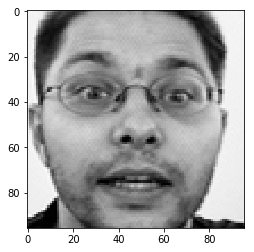

In [25]:
plt.imshow(X_test[0].reshape(96,96), cmap='gray')

In [26]:
# predicting labels for one example test image
predictions = model.predict(X_test[0].reshape(-1,96,96,1))

In [27]:
predictions

array([[68.05707 , 37.53912 , 29.294226, 36.598286, 61.199566, 37.448658,
        75.254944, 37.811245, 36.593662, 37.00554 , 21.806757, 36.93189 ,
        58.170044, 26.161213, 83.10403 , 27.998203, 39.115982, 24.63422 ,
        14.527728, 26.019316, 50.41887 , 52.805546, 65.63562 , 77.84159 ,
        32.349552, 76.736145, 49.203873, 70.62477 , 48.642498, 86.46949 ]],
      dtype=float32)

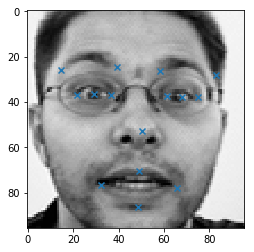

In [28]:
plt.imshow(X_test[0, :, :, 0].reshape(96,96), cmap='gray')
plt.scatter(predictions.reshape(30,)[range(0,30,2)], predictions.reshape(30,)[range(1,30,2)], marker='x')


In [29]:
y_test = model.predict(X_test)

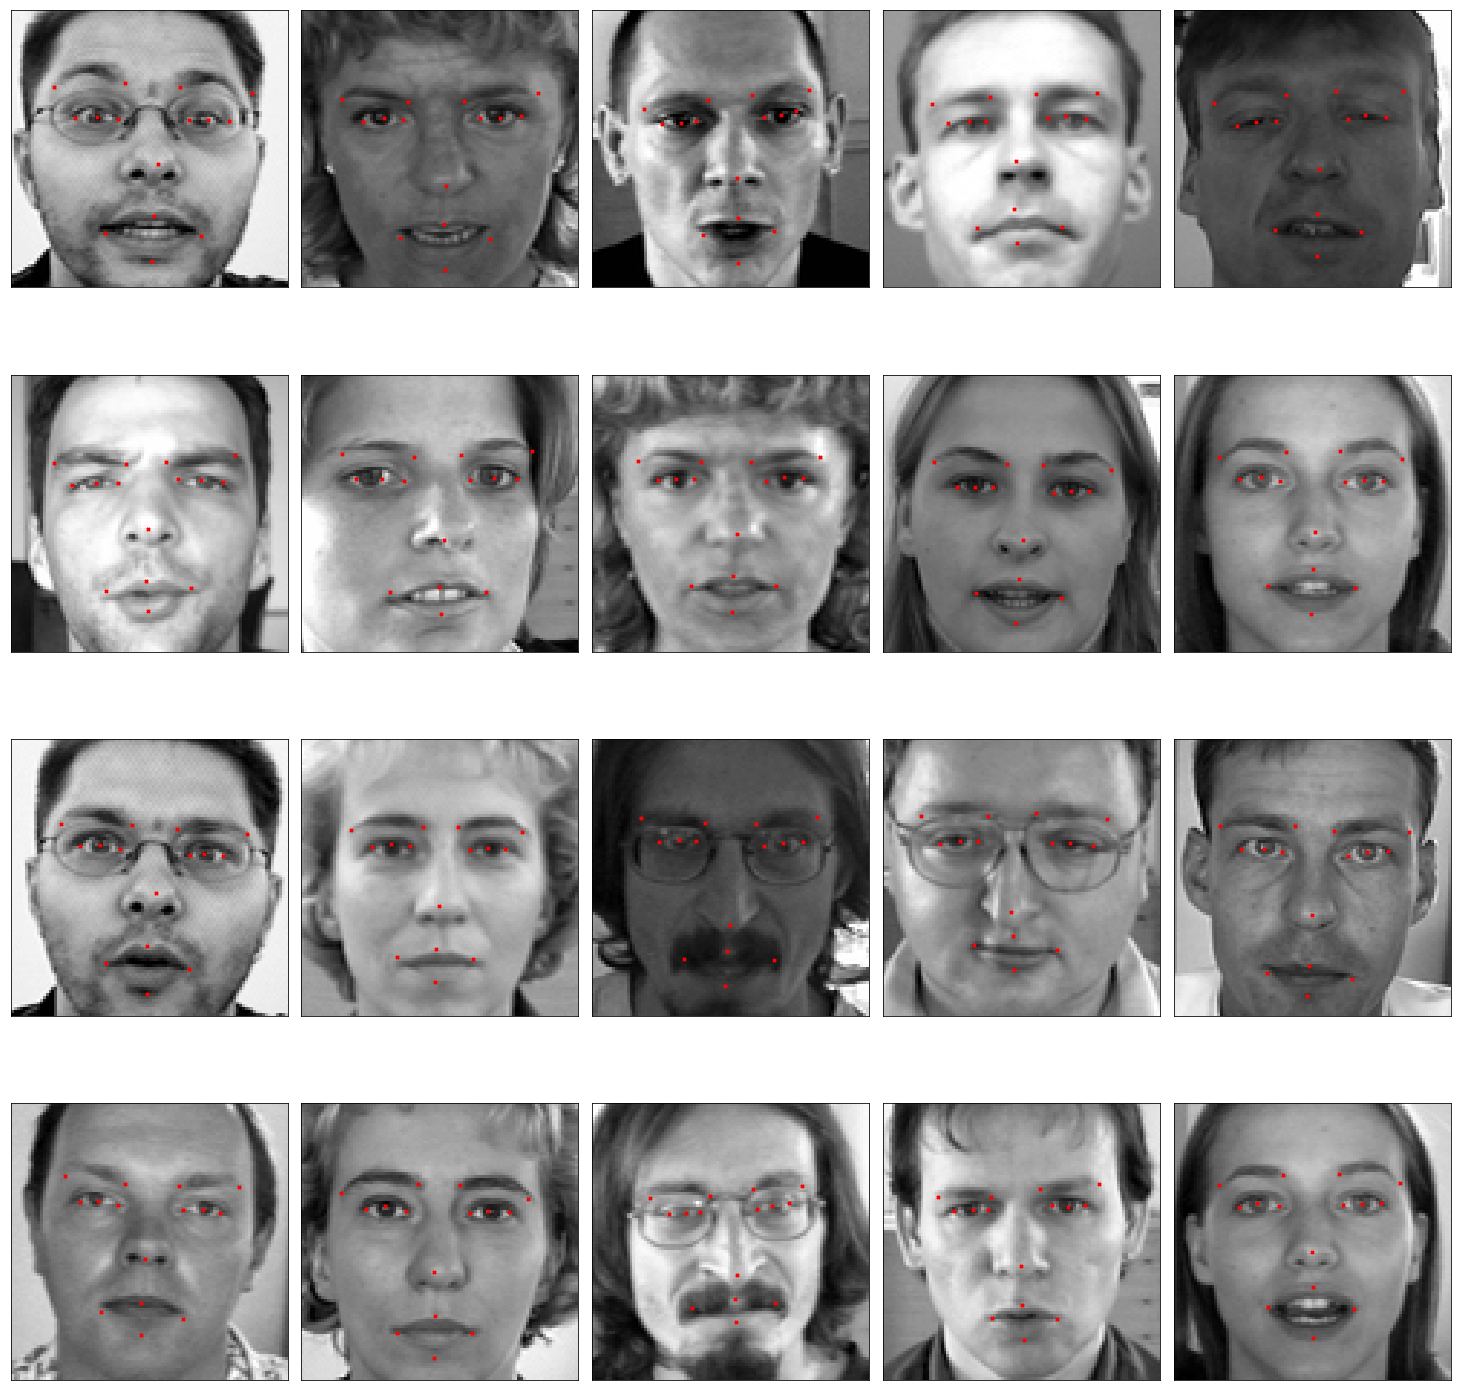

In [30]:
def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10, color='red')

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_test[i], y_test[i], ax)
    
plt.show()

### Model Results

As seen above, training for 50 epochs has produced very good results, giving us an RMSE of 1.6 (2-ConvolutionLayer-32-48-LayerSizes-1-DenseLayer-WithDropout).  And with the simplified model, this didn't warrant for being run on an EC2 instance.  The resulting model has been saved, so that predictions on any fresh data / test dataset can be done without having to retrain.  This is done by invoking 'model.save()' command. 


The Kaggle contest from 2 years ago had an RMSE of 1.53 on public leaderboard and 1.28 on private leaderboard.  



### Further Modeling Exercise

* Analysis of Dataset shows that there are 8 labels (among the 30 facial keypoints) which have values in 7000 samples.  The remaining 22 labels are seen to have values in around 1700+ samples.  So, the dataset can be split into 2 sets and individual models can be built so that we have more training data for prediction of those 8 labels.

* Image pre-processing techniquest such as blurring, contrast enhancements, histogram equalization can be applied on the images that would help enhance the training process and possibly produce a more robust model


In [37]:
tb_snapshot = cv2.imread('TensorBoard-Snapshot-20181203.png')

Below is a snapshot of the TensorBoard for the Rockstar Model Run


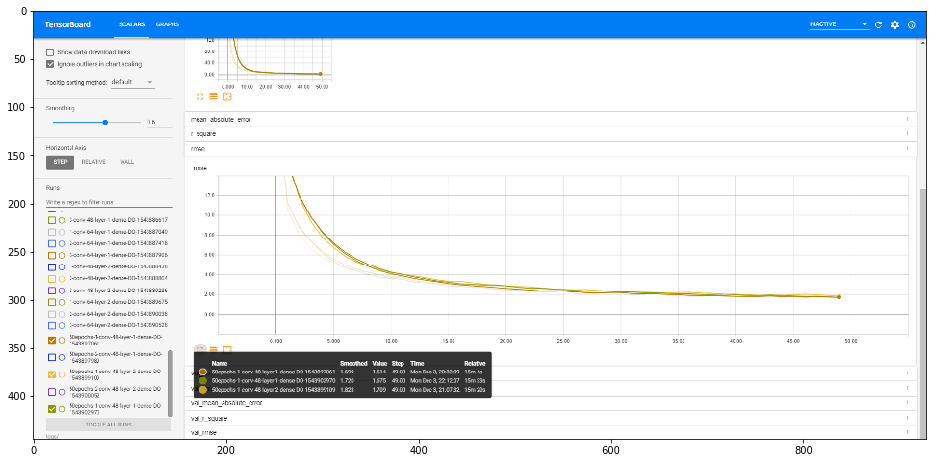

In [38]:
print("Below is a snapshot of the TensorBoard for the Rockstar Model Run")
plt.figure(figsize=(16,16))
plt.imshow(tb_snapshot)